<a href="https://colab.research.google.com/github/mlites/mlites2019/blob/master/intro_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Linear Regression and Gradient Descent

Hello! In this exercise we'll peek behind the scenes at the deceptively simple linear regression algorithm by implementing a version using "gradient descent".

Along the way we'll learn to do some data manipulation in python using Pandas and NumPy, and learn how to separate our data into Training and Test sets for validation.

If you haven't already, make sure you run [intro_kaggle.ipynb](https://colab.research.google.com/github/mlites/mlites2019/blob/master/kaggle_introduction.ipynb) to download the necessary datasets


More background
* [Introduction to Machine Learning Algorithms: Linear Regression](https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a)

* [Quick start to Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)


## Outline

1. import necessary packages
2. Load Iditarod data
3. Do some date and time conversion
4. Generate some new features
5. Plot some data
6. Fit regression with sklearn
7. Fit regression with gradient descent

## Getting Started

In [0]:
import pandas as pd #import Pandas under the shortcut 'pd'
import numpy as np #import NumPy; NumPy is the fundamental package for scientific computing with Python
import matplotlib.pyplot as plt #MatPlotLib is a plotting library

## Exploring the Iditarod Dataset

In [449]:
# first lets load the Iditarod data into a pandas dataframe in a variable called 'iditarod'

iditarod = pd.read_csv("iditarod.csv")
iditarod.tail()

,Number,Name,Status,Country,Checkpoint,Latitude,Longitude,Distance,Time,Speed,Arrival Date,Arrival Time,Arrival Dogs,Elapsed Time,Departure Date,Departure Time,Departure Dogs
1141,43,Jimmy Lebling,Rookie,United States,Nome,64.4964,-165.3996,22.0,2.95,7.46,03/18/2017,12:19:06,12.0,0.0,NaN,NaN,NaN
1142,47,Paul Hansen,Rookie,United States,Nome,64.4964,-165.3996,22.0,3.07,7.17,03/18/2017,14:19:11,12.0,0.0,NaN,NaN,NaN
1143,35,Alan Eischens,Veteran,United States,Nome,64.4964,-165.3996,22.0,3.50,6.29,03/18/2017,14:39:46,16.0,0.0,NaN,NaN,NaN
1144,53,Peter Reuter,Rookie,United States,Nome,64.4964,-165.3996,22.0,3.60,6.11,03/18/2017,14:45:38,9.0,0.0,NaN,NaN,NaN
1145,31,Cindy Abbott,Veteran,United States,Nome,64.4964,-165.3996,22.0,3.07,7.17,03/18/2017,14:57:31,12.0,0.0,NaN,NaN,NaN


There is a bunch of data here about each musher, like when they arrived at each checkpoint, how long it took, what their speed was, and how many dogs they checked in or out.

Let's explore the data a bit to see what it looks like. Say we're interested in how the number of dogs on the team affects the speed, we can plot that using the MatPlotLib library.

Let's look at the speed versus the number of dogs dropped by each team.

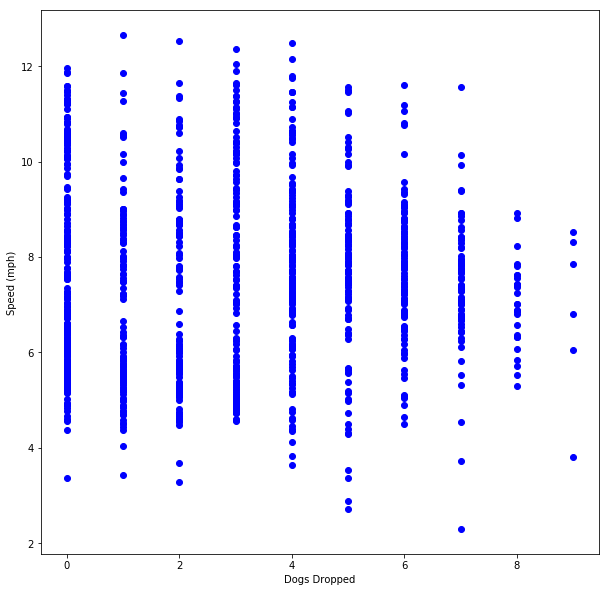

In [450]:
iditarod["Dogs_dropped"] = 16 - iditarod["Arrival Dogs"] #everyone starts with 16 dogs
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.scatter(iditarod["Dogs_dropped"],iditarod["Speed"],color='blue') # the scatter command make a scatter plot
plt.xlabel("Dogs Dropped")
plt.ylabel("Speed (mph)")
plt.show()

**Questions:**
* What do you think, is there a trend?
* Do mushers go faster when they have more dogs?
* What other factors might affect their speed?


Let's do some feature conversions and dig into the data a bit more.

In [452]:
#let's drop values that have NA or NaN's
iditarod = iditarod.dropna()

#then convert the times into machine-readable timestamps

# import the datetime module
from datetime import datetime

# get the Date and Time into a new temporary dataframe
# pd.loc[] accesses rows or columns in a dataframe by character labels
dt = iditarod.loc[:, ['Arrival Date', 'Arrival Time']] # ':' means 'all rows'

# 'apply' applies a function (in this case an anonymous 'lambda' function) to each row (axis=1) of the new dataframe
# the function concatenates the Date and Time and converts them into a special 'datetime' object
# which then gets saved back into the original dataframe

iditarod['Arrival_datetime'] = dt.apply(lambda x: datetime.strptime(x[0] + '/' + x[1], '%m/%d/%Y/%H:%M:%S'), axis=1)

# another way to make datetime objects in pandas
# iditarod["Arrival Time"] = pd.DatetimeIndex(iditarod["Arrival Time"],dtype='datetime64[ns]')
# iditarod["Departure Time"] = pd.DatetimeIndex(iditarod["Departure Time"],dtype='datetime64[ns]')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Now we can plot the number of Dogs Dropped as a function of the Datetime

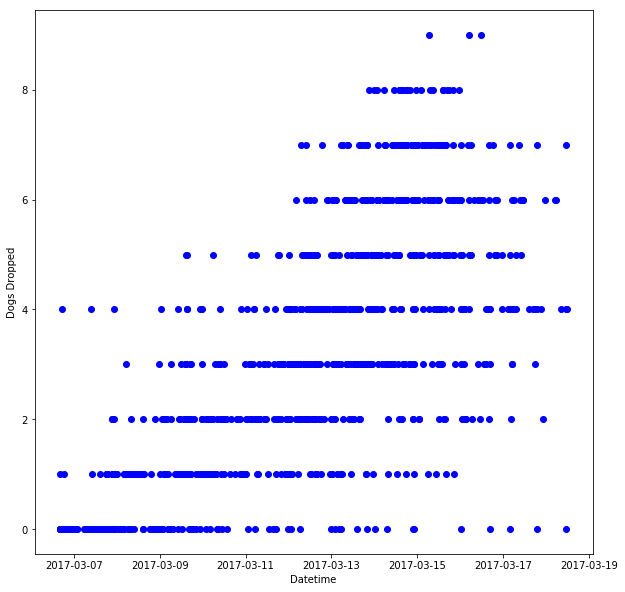

In [18]:
# plot_date is a matplotlib command to use when you're plotting a date or time
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.plot_date(iditarod["Arrival_datetime"],iditarod["Dogs_dropped"],color='blue') #make a scatter plot
plt.xlabel("Datetime")
plt.ylabel("Dogs Dropped")
plt.show()


Is there a trend here?

It kind of looks like it, but how can we tell for sure?

Let's look at one more example.

In [19]:
# let's find the cumulative time and distance traveleled to each checkpoint

# first we'll find the unique checkpoints like this:
iditarod["Checkpoint"].unique()

# then from the Iditarod website we can find the cumulative distances
# to each unique checkpoint
# https://iditarod.com/race-map/


array(['Nenana', 'Manley', 'Tanana', 'Ruby', 'Galena', 'Huslia',
       'Koyukuk', 'Nulato', 'Kaltag', 'Unalakleet', 'Shaktoolik', 'Koyuk',
       'Elim', 'White Mountain', 'Safety'], dtype=object)

In [9]:
# PS the race started in Fairbanks in 2017 because of global warming

# inputing them into a new dictionary ('dict') like so:
cumulative_dist = {
'Fairbanks'	: 0,
'Nenana'	: 71,
'Manley'	: 161,
'Tanana'	: 227,
'Ruby'	: 346,
'Galena'	: 396,
'Huslia'	: 478,
'Koyukuk'	: 564,
'Nulato'	: 586,
'Kaltag'	: 633,
'Unalakleet'	: 718,
'Shaktoolik'	: 758,
'Koyuk'	: 808,
'Elim'	: 856,
'White Mountain'	: 902,
'Safety'	: 957,
'Nome'	: 979
}

# now we can insert those into the iditarod dataframe using the 'replace()' function like so:
# this function replacess e.g. "Huslia" with "478" from the original column ("Checkpoint")
iditarod["Distance_traveled"] = iditarod["Checkpoint"].replace(cumulative_dist)

# finally lets convert the timestamps into hours elapsed since the the start of the race
# we subtract the Arrival time from the race start time and use the .astype() function to report the time difference in hours
# I know what you're saying -- this isn't perfectly accurate because they actually do a 2-minute staggered start, but I'll leave that as an exercise for the reader

racestart = pd.Timestamp('2017-03-06 11:00:00.00000')
iditarod["Elapsed_time"] = (iditarod["Arrival_datetime"] - racestart).astype('timedelta64[h]')

# now let's take a look at our new features
iditarod.head()

,Number,Name,Status,Country,Checkpoint,Latitude,Longitude,Distance,Time,Speed,Arrival Date,Arrival Time,Arrival Dogs,Elapsed Time,Departure Date,Departure Time,Departure Dogs,Arrival_datetime,Distance_traveled,Elapsed_time
72,6,Linwood Fiedler,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.05,11.88,03/06/2017,16:11:00,16.0,3.93,03/06/2017,20:07:00,16.0,2017-03-06 16:11:00,71,5.0
73,5,Cody Strathe,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.22,11.50,03/06/2017,16:19:00,16.0,0.12,03/06/2017,16:26:00,16.0,2017-03-06 16:19:00,71,5.0
74,4,Misha Wiljes,Rookie,Czech Republic,Nenana,64.5952,-149.0897,60.0,5.25,11.43,03/06/2017,16:19:00,15.0,5.93,03/06/2017,22:15:00,15.0,2017-03-06 16:19:00,71,5.0
75,9,Michelle Phillips,Veteran,Canada,Nenana,64.5952,-149.0897,60.0,5.18,11.58,03/06/2017,16:25:00,16.0,3.48,03/06/2017,19:54:00,16.0,2017-03-06 16:25:00,71,5.0
76,15,Martin Buser,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.02,11.96,03/06/2017,16:27:00,16.0,0.23,03/06/2017,16:41:00,16.0,2017-03-06 16:27:00,71,5.0


Ok, your turn!

Fill in the missing details to make a scatter plot of the Elapsed Time as a function of the Distance Traveled

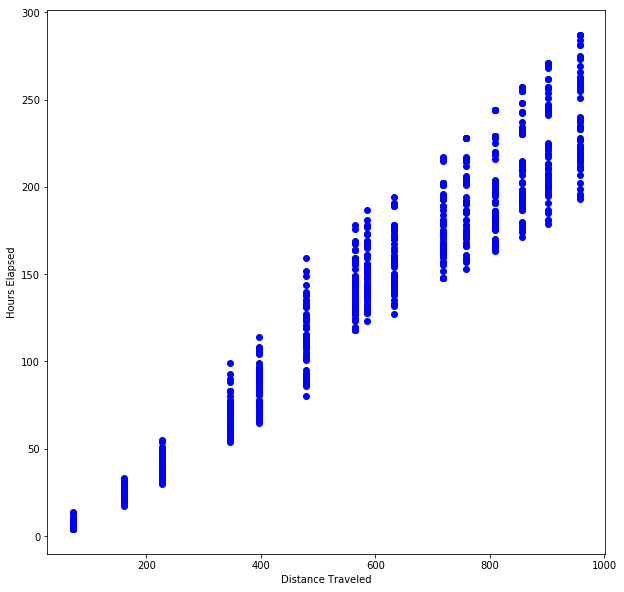

In [0]:
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.scatter(iditarod[""],iditarod[""],color='blue') #make a scatter plot
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")
plt.show()

You'll notice that this dataset violates several rules of traditional statistical analysis:
* The sample mean and variances are not independent, in fact they are correlated
* The samples are not i.i.d. or "independent and identically distributed", since each time point 't' depends on 't-1'
* Which means this is a time series, though for now we're going to ignore this
* Here's a nice online book about analysing time series data properly:
    * [Forecasting: principles and practice](https://otexts.com/fpp2/stationarity.html)
* [How (not) to use Machine Learning on Time Series Forecasting](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

## Introducing Training and Testing Sets

In Machine Learning, the way we validate how well the machines are learning is by using two subsets of any given dataset: a Train set, and a Test set. Let's say we split the data 80/20 between these subsets, this means we'll usen80% of the data to Train our model, and reserve 20% to Test whether our predictions are any good.


**Some questions to ponder:**

* Why don't we train on the whole data set?
* Wouldn't we get a better model that way?


First, let's work with the Elapsed Time and Distance Traveled data, and split it into Train and Test sets.

We'll use scikit-learn, a simple but powerful machine learning toolkit for python.

docs: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [106]:
import sklearn #import the scikit-learn package
from sklearn.model_selection import train_test_split #import the train_test_split function

x = iditarod["Distance_traveled"]
y = iditarod["Elapsed_time"]

# here we tell sklearn to split our data and reserve 20% for the test set
# train_test_split automatically shuffles the data before returning the splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# we need to convert the data to numpy array and reshape it for input into the linear model function
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(-1,1) # the -1 indicates that that dimension will be inferred from the data
x_test = x_test.reshape(-1,1) # so (-1,1) says to reshape the data into 1 column that has the same number of rows as the data
y_train = y_train.reshape(-1,1) # the -1 indicates that that dimension will be inferred from the data
y_test = y_test.reshape(-1,1) # so (-1,1) says to reshape the data into 1 column that has the same number of rows as the data

# mimic "head" to preview the x_test set by taking a top slice of the array
print(x_test[:10]) # notice x_test values are integers

# to "tail" take a bottom slice
print(y_test[-10:]) # notice y_test values are floats


[[718]
 [856]
 [902]
 [856]
 [586]
 [478]
 [564]
 [902]
 [902]
 [718]]
[[233.]
 [  6.]
 [ 22.]
 [236.]
 [108.]
 [274.]
 [165.]
 [ 87.]
 [  6.]
 [188.]]


## Simple Linear Regression

It turns out, for linear regression it is often possible to calculate the best possible coefficients exactly.

### Ordinary Least Squares
Here's an example implementing an exact solution to the linear regression problem using Ordinary Least Squares.

However, since this is not possible for every function, we will also use machine learning, and will go through an example using gradient descent from scratch.



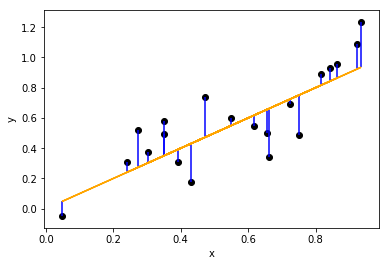

In [422]:
#generate some random correlated data
n = 20
x = np.random.rand(n)
y = np.random.normal(loc=x,scale=0.2,size=n)
dy = x - y

fig, ax = plt.subplots()

ax.scatter(x,y,label="observed",color="black")
ax.plot(x,x,label="predicted",color="orange")
ax.vlines(x,y,y+dy,label="residuals",color="blue")

plt.xlabel("x")
plt.ylabel("y")
plt.show()

In the plot above, the orange line is our *estimator* or *best fit line*, which we want to optimize to best predict future values of $y$ given $x$.

The blue lines are *residuals* ($r$), or the difference between the predicted and actual values for any given $x$.

The goal of simple linear regression is to find the line 
$$y_i = mx_i+b+r_i$$ that optimizes our ability to predict future $y$s given future $x$s.

* $x_i$ is the $i$th value at which a measurement of $y$ was taken
* $y_i$ is the observed value at $x_i$
* $r_i$ is the observed residual at $x_i$
* $\hat y_i$ is the predicted value at $x_i$
* $\bar x = \frac{1}{n}\sum_{i=1}^{n} x_i$, the mean of the $x$s
* $\bar y= \frac{1}{n}\sum_{i=1}^{n} y_i$, the mean of the $y$s


It turns out that for simple linear regression (that is, when there is only one input and one output variable), the best estimates of the slope ($m$) and intercept ($b$) can be obtained by minimizing the sum of the squared errors of prediction.

$$SSE = \sum_{i=1}^{n}  r_i^2$$

Ideally, we want to find the values of $m$ and $b$ that minimize the value of the SSE function. Mathematically, you can do that by expressing SSE in terms of $m$ and $b$, taking the derivatives of SSE with respect to $m$ and $b$, setting these derivatives to zero, and solving for $m$ and $b$. However, we won't go into that derivation here and jump straight to the conclusions, which are:

$$m = \frac{Cov(x,y)}{Var(x)}$$

where $Cov(x,y)$ is the covariance:

$$Cov(x,y) = \frac{1}{n}\sum_{i=1}^{n}(x_i - \bar x)(y_i - \bar y)$$

and $Var(x)$ is the variance:

$$Var(x) = \frac{1}{n}\sum_{i=1}^{n} (x_i - \bar x)^2$$

and

$$b = \bar y - m \cdot \bar x$$


In the example below, we'll calculate these values for the training set

In [426]:
# means of x and y
xbar = np.mean(x_train)
ybar = np.mean(y_train)

# calculate Cov(x,y) and Var(x)
cov_xy = (1/n)*np.sum((x_train - mean_x) * (y_train - mean_y))
var_x = (1/n)*np.sum((x_train - mean_x) ** 2)

# get the estimates of the coefficients using Ordinary Least Squares
m = cov_xy / var_x
b = ybar - (m * xbar)

# Print the coefficients
print("y = %.2fx + %.2f" % (m, b))

# import the r2_score module from sklearn to calculate the R^2 metric
from sklearn.metrics import r2_score # import the r2_score module from sklearn

# compare our test set to our training set
y_pred = m*x_test + b
print('R2 Score:',r2_score(y_test,y_pred))


y = 0.27x + -15.35
R2 Score: 0.9381785364698395


These are the gold standard coefficients and R2 value that we'll compare the other methods to below.

## sklearn LinearRegression

Now that we've split the data into training and testing sets, let's do some linear regression. We'll use the LinearRegression module from sklearn first.

In [107]:
from sklearn.linear_model import LinearRegression # import the LinearRegression module from sklearn

clf = LinearRegression() # initiate an object of Class LinearRegression
clf.fit(x_train,y_train) # call the fit() function to fit the training data x_train and y_train

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

That's it!

Let's print out the formula for our best fit line using the coefficients found within the 'clf' object

In [364]:
# the formula for the best fit line is
slope = clf.coef_[0]
intercept = clf.intercept_
print("y = " + str(slope[0]) + "x" + " + " + str(intercept[0])) #str() converts a numeric to a string

# get control of those significant figures by printing with nicer formatting
print("y = %.2fx + %.2f" % (slope, intercept)) # %.2f says to format a _f_loating-point number to 2 decimal places

y = 0.26751697604093494x + -15.346844507755577
y = 0.27x + -15.35


Now that we have a model trained on the training set, we can use it to predict new values.

For example, if the Iditarod was 1100 or 1200 miles long instead of 1000, how many hours would it take the average musher to finish?


In [108]:
y_pred = clf.predict([[1100],[1200]]) # we need double brackets because predict() expects an array of arrays
print(y_pred)

[[278.92182914]
 [305.67352674]]


Now let's plot the best fit line over the training and testing data

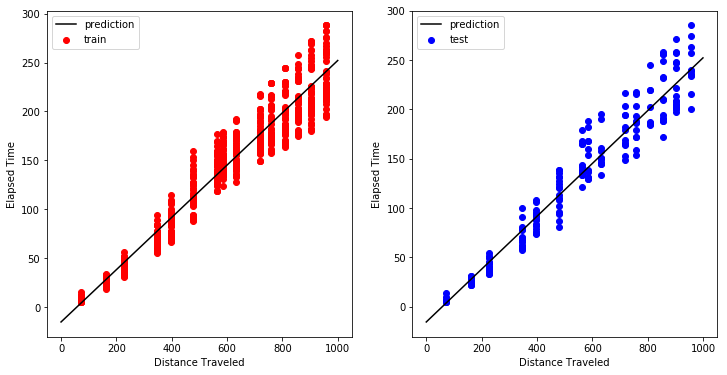

In [367]:
x_fit = np.linspace(0,1000, 50) # linspace(start, stop, num) generates a linearly-spaced numeric array
y_fit = slope*x_fit + intercept

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1) #subplot(nrows, ncols, index) allows for multiple plots on one page
plt.scatter(x_train,y_train,color='red',label='train')
plt.plot(x_fit,y_fit,color='black',label = 'prediction')
plt.legend()
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")

plt.subplot(1, 2, 2)
plt.scatter(x_test,y_test,color='blue',label='test')
plt.plot(x_fit,y_fit,color='black',label = 'prediction')
plt.legend()
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")

plt.show()

Finally, let's use the Test set to validate how well we did on our predictions.

We'll use the R<sup>2</sup> test to do so along with the sklearn predict() function


In [111]:
# first we'll use the sklearn predict() function
y_pred = clf.predict(x_test)
print('R2 Score:',r2_score(y_test,y_pred))

# if we wanted to do the prediction manually we could do it like this
y_pred = slope * x_test + intercept
print('R2 Score:',r2_score(y_test,y_pred))


R2 Score: 0.9381785364698394
R2 Score: 0.9381785364698394


Not too bad!

**Question:** What features might we add to make our predictions better next time?

## Linear Regression by Gradient Descent

"Training a machine learning algorithm or a neural network is really just the process of minimizing the cost function"

Let's see how that works under the hood


Some background info:
  * [Linear Regression in Python](https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606)
  
  * [Linear Regression Using Gradient Descent in 10 Lines of Code](https://towardsdatascience.com/linear-regression-using-gradient-descent-in-10-lines-of-code-642f995339c0)
  
  *  [Linear Regression using Gradient Descent](https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931)

* This [video](https://www.youtube.com/embed/yFPLyDwVifc) from Andrew Ng's Machine Learning course at Stanford may be useful



### Derivation

The nature of the gradient descent method is to iteratively update our best guesses for each parameter by calculating the gradients (or partial derivatives) of the system at each iteration for each parameter. Then we use the gradients to adjust the direction and rate of travel through the parameter space.


In the following derivation we'll define $y_i$ as the observed value at $x_i$ and $\hat{y}_i$ as the predicted value at $x_i$


Our linear equation for prediction is: $$\hat{y}_i = mx_i + b$$


For our Error (or Loss, or Cost) function we'll use the Root Mean Square Error (RMSE), which is the standard deviation of the residuals (prediction errors). This isn't the only possible Error function and depending on the application, several others are used in machine learning.

$$E =\frac {1}{n}\sum(y_i - \hat{y}_i)^2$$

To calculate the gradients, we'll need to take the partial derivatives with respect to each of the parameters we'll be adjusting, in this case $m$ (the slope) and $b$ (the intercept). Let's walk through the derivation.

Substituting for $\hat{y}_i$, we get
$$E =\frac {1}{n}\sum \big(y_i - (mx_i + b)\big)^2$$

Expanding, we get
$$E =\frac {1}{n}\sum\big(y_i - (mx_i + b)\big)\big(y_i - (mx_i + b)\big)$$

and  FOILing we get
$$E =\frac {1}{n}\sum y_i^2 - 2y_i(mx_i + b) + (mx_i+b)^2$$

and just for clarity let's multiply the whole thing out
$$E =\frac {1}{n}\sum y_i^2 - 2mx_iy_i - 2by_i +m^2x_i^2 + 2bmx_i+b^2$$

Then to get the gradients with respect to $m$ and $b$ we take the partial derivatives w.r.t. each, remembering that constants differentiate to 0

$$\frac{\partial E}{\partial m} = \frac {1}{n}\sum 0 - 2x_iy_i - 0 + 2mx_i^2 + 2bx_i + 0$$

Pulling out a factor of $-2x_i$, we get

$$\frac{\partial E}{\partial m} = \frac {1}{n}\sum -2x_i(y_i - mx_i - b)$$

and finally rearranging and using a simpler functional notation, we get
$$D_m = -\frac {2}{n}\sum x_i\big(y_i-(mx_i +b)\big)$$

which could also be written
$$D_m = -\frac {2}{n}\sum x_i\big(y_i-\hat y_i\big)$$

As for $b$, when we take the partial derivative we get
$$\frac{\partial E}{\partial b} =\frac {1}{n}\sum 0 - 0 - 2y_i + 0 + 2mx_i+2b$$


Pulling out a factor of $-2$ and rearranging as before we get
$$D_b = -\frac{2}{n}\sum \big(y_i - (mx_i + b)\big)$$

which could also be written
$$D_b = -\frac {2}{n}\sum \big(y_i-\hat y_i\big)$$


Now we can use these gradients to update our guesses using the following equations, where $L$ is the *learning rate*. Again, this is just one possible way to update our guesses, and other more sophisticated ways are often used in machine learning.

$$m = m - L \cdot Dm $$
$$b = b - L \cdot Db $$





### Implementation

In [0]:
## Linear Regression by gradient descent using least squares error

# let's define a function that implements gradient descent for linear regression
# using the error criterion E = (1/n)*sum((y_i - yhat_i)^2)

def linear_regression_lse(x_i, y_i, m=0, b=0, L=1e-6, epochs=1000, plotevery=100):
  grid = widgets.Grid(1, 1) #setup colab grid output
  n = float(len(y_i)) #calculate length of input data
  Esave = np.full(epochs, np.nan) #initialize an array of 'epochs' length with NaNs
  for i in range(epochs): #perform loop 'epochs' times
      yhat_i = m * x_i + b #calculate predictions using current guesses
      E = (1/n)*np.sum((y_i - yhat_i)**2) #calculate the cost function for display
      Esave[i] = math.log(E) #save the logarithm of the cost function

      # now we update our guesses
      # note that we always update the values simultaneously rather than sequentially
      Dm = (-2/n) * np.sum(x_i * (y_i - (m * x_i + b))) #calculate the gradient of (derivative w.r.t.) the slope
      Db = (-2/n) * np.sum(y_i - (m * x_i + b)) #calculate the gradient of (derivative w.r.t.) the intercept
      m = m - L * Dm # update the slope
      b = b - L * Db # update the intercept
      
      # do some plotting so we can see how we're doing
      if(i%plotevery == 0 or i+1 == epochs or i==0): #plot every 'plotevery' iterations
        with grid.output_to(0, 0): #tell colab to plot to a certain grid cell
          grid.clear_cell() #clear the grid cell to plot to
          plt.figure(figsize=(12,6)) #plot a new figure with width=12 height=6
          plt.subplot(1, 2, 1) # slot first figure into index 1 of a 1-row 2-column grid
          plt.scatter(x_i,y_i,color="red",label='y_i') #plot the observed points
          plt.plot(x_i,yhat_i,color='black',label = 'yhat_i') #plot the prediction line
          plt.legend() #plot the legend
          plt.xlabel("Distance Traveled") #plot x label
          plt.ylabel("Elapsed Time") #plot y label
          plt.title("step=" + str(i) + "   log(cost)=%.5f" % Esave[i] + "   y = %.2fx + %.2f" % (m, b)) # plot title
          plt.subplot(1, 2, 2) # slot second figure into index 2 of a 1-row 2-column grid
          plt.scatter(range(len(Esave)),Esave) #plot the costs
          plt.xlabel("iterations")
          plt.ylabel("log(E)")
          try: #try this...
            plt.ylim(Esave[i],Esave[i-round(i/1.11)]) #scale the y axis to fit the last 90% of the points
          except: #but if it doesn't work, do this...
            plt.ylim(0,max(Esave)) #scale the y axis to all of the points

            #           time.sleep(0.5) #sleep for half a second if it's updating too fast

        # when we're done with all the iterations, return the requested values
  return m, b, E


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

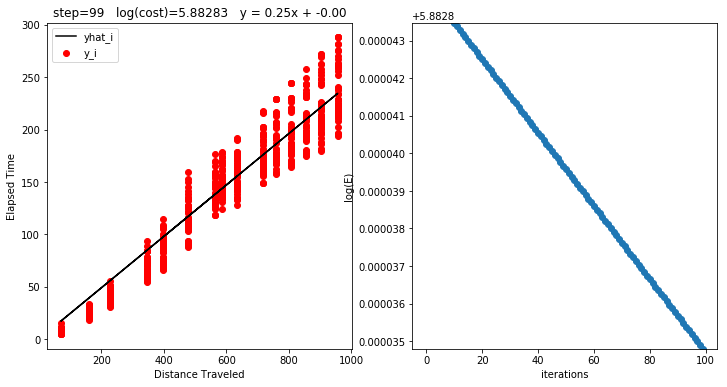

<IPython.core.display.Javascript object>

y = 0.25x + -0.00
R2 Score: 0.9287153586894055


In [447]:
# widgets are some Colab-specific tools
# https://colab.research.google.com/notebooks/widgets.ipynb
from google.colab import widgets
import math # the math library contains useful functions like math.log()

lg = linear_regression_lse(x_train, y_train, L=1e-6, epochs=100, plotevery=5)
print("y = %.2fx + %.2f" % (lg[0], lg[1]))

y_pred = lg[0]*x_test + lg[1]
print('R2 Score:',r2_score(y_test,y_pred))


**Questions**:
* How does the R2 score compare to the other methods?
* What might we do to get a better fit?


Here is some further reading material
* [Ordinary Least Square Method](https://mubaris.com/posts/linear-regression/)
* [Learning Python Regression Analysis](https://medium.com/@dhwajraj/python-regression-analysis-part-3-ordinary-least-squares-d419322c8da2)
* [Linear Regression with NumPy](https://www.cs.toronto.edu/~frossard/post/linear_regression/)


## Conclusion

Well done, we learned a lot in this lesson!

* You used pandas, numpy, matplotlib, and sklearn, all of which are common packages that we will see over and over again in ML
* You read data from a CSV file into a pandas dataframe
* You calculated the mean, variance, and covariance of some data
* You generated new features from existing features
* You converted dates and times
* You generated plots using scatter() and plot_date()
* You generated a dictionary and used replace() to make substitutions in it
* You split your data into train and test sets using sklearn
* You ran a linear regression in sklearn
* You implemented a gradient descent algorithm
* You validated your models using the R2 score
* You made dynamic plots in Colab

# Exercises

## Exercise 1

Apply the sklearn LinearRegression() method to a different subset of the Iditarod data by predicting the number of dogs dropped as a function of the distance traveled.

You'll need to:
* split the data into Train and Test sets
* fit a linear model
* make predictions on y_test given x_test
* validate your model using the R2 score on the test data

I'll get you started:

In [451]:
import sklearn #import the scikit-learn package
from sklearn.model_selection import train_test_split #import the train_test_split function
from sklearn.linear_model import LinearRegression # import the LinearRegression module from sklearn
from sklearn.metrics import r2_score # import the r2_score module from sklearn

x = iditarod["Distance_traveled"]
y = iditarod["Dogs_dropped"]


KeyError: ignored

## Exercise 2

sklearn has several different linear regressors, including some that are more robust to outliers than is the Least Squares method.  Instead of TheilSenRegressor